In [257]:
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio import Seq
from Bio.Align.Applications import MuscleCommandline
from Bio.Align.Applications import ClustalwCommandline
from Bio import Phylo
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.Consensus import *

warnings.filterwarnings('ignore')

In [124]:
species_dict = {
    1: ("Cycas revoluta", "Cycadaceae"),
    2: ("Ginkgo biloba", "Ginkgoaceae"),
    3: ("Ephedra sinica", "Ephedraceae"),
    4: ("Larix decidua", "Pinaceae"),
    5: ("Gnetum gnemon", "Gnetaceae"),
    6: ("Welwitschia mirabilis", "Welwitschiaceae"),
    7: ("Sciadopitys verticillata", "Sciadopityaceae"),
    8: ("Juniperus communis", "Cupressaceae"),
    9: ("Araucaria angustifolia", "Araucariaceae"),
    10: ("Nageia nagi", "Podocarpaceae"),
    11: ("Zamia furfuracea", "Zamiaceae")
}

# Data preparation

## Data exploration

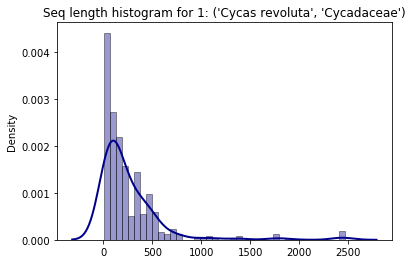

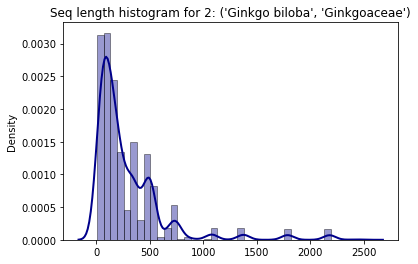

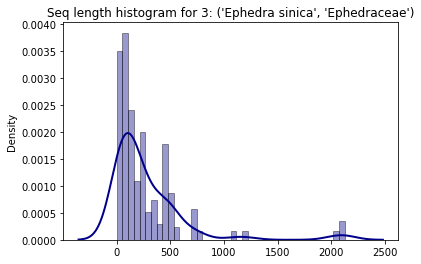

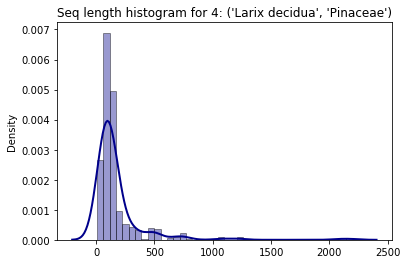

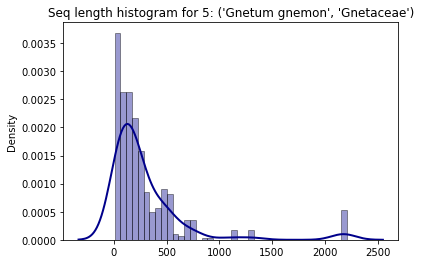

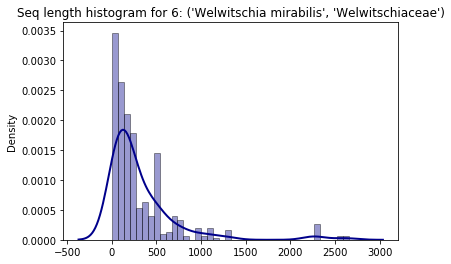

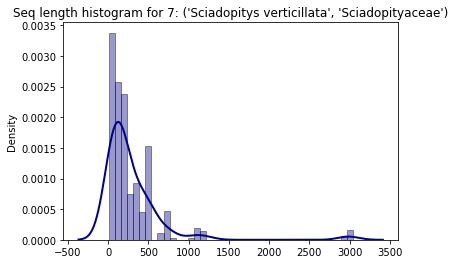

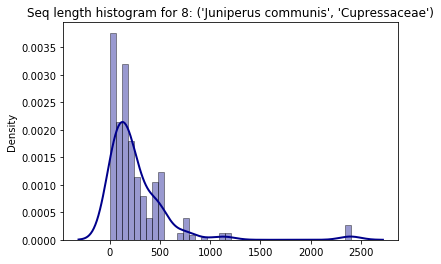

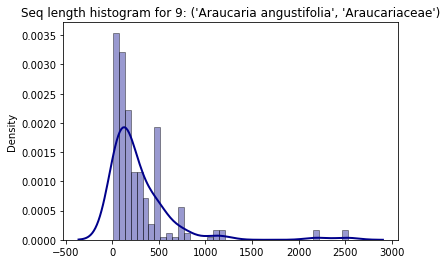

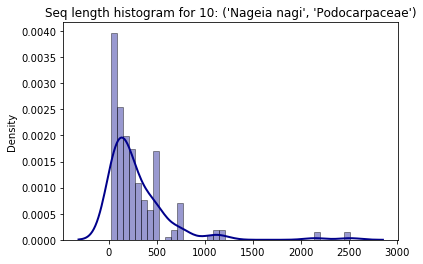

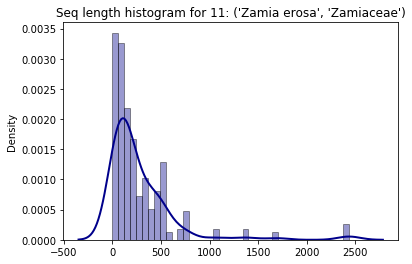

In [265]:
for i in range(1, 12):
    records = list(SeqIO.parse("seqs/downloaded/" + str(i) + ".fasta", "fasta"))
    lens = []
    for record in records:
        lens.append(len(record))
    sns.distplot(np.array(lens), hist=True, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
    plt.title("Seq length histogram for " + str(i) + ": " + str(species_dict.get(i)))
    plt.show()

In [271]:
for i in range(1, 12):
    records = list(SeqIO.parse("seqs/downloaded/" + str(i) + ".fasta", "fasta"))
    lens = []
    for record in records:
        lens.append(len(record))
    min_len = 50
    max_len = 1000
    count = sum(1 for l in lens if l > min_len and l < max_len)
    print("selected seqs in " + str(i) + " " + str(species_dict.get(i)) + " : " + str(count))

selected seqs in 1 ('Cycas revoluta', 'Cycadaceae') : 316
selected seqs in 2 ('Ginkgo biloba', 'Ginkgoaceae') : 6666
selected seqs in 3 ('Ephedra sinica', 'Ephedraceae') : 254
selected seqs in 4 ('Larix decidua', 'Pinaceae') : 434
selected seqs in 5 ('Gnetum gnemon', 'Gnetaceae') : 401
selected seqs in 6 ('Welwitschia mirabilis', 'Welwitschiaceae') : 344
selected seqs in 7 ('Sciadopitys verticillata', 'Sciadopityaceae') : 364
selected seqs in 8 ('Juniperus communis', 'Cupressaceae') : 289
selected seqs in 9 ('Araucaria angustifolia', 'Araucariaceae') : 224
selected seqs in 10 ('Nageia nagi', 'Podocarpaceae') : 272
selected seqs in 11 ('Zamia erosa', 'Zamiaceae') : 294


In [ ]:
for i in range(1, 12):
    records = list(SeqIO.parse("seqs/downloaded/" + str(i) + ".fasta", "fasta"))
    lens = []
    for record in records:
        lens.append(len(record))
    min_len = 50
    max_len = 1000
    count = sum(1 for l in lens if l > min_len and l < max_len)
    print("selected seqs in " + str(i) + " " + str(species_dict.get(i)) + " : " + str(count))b

## Sequence selection

In [205]:
for i in range(1, 12):
    records = list(SeqIO.parse("seqs/downloaded/" + str(i) + ".fasta", "fasta"))
    records = records[0:270]
    for j in range(0, len(records)):
        records[j].id = str(i) + "_" + str(j)
    SeqIO.write(records, "seqs/selected/" + str(i) + ".fasta", "fasta")

### merging selected sequences

In [206]:
merged = list()
for i in range(1, 12):
    records = list(SeqIO.parse("seqs/selected/" + str(i) + ".fasta", "fasta"))
    merged = merged + records
    
SeqIO.write(merged, "seqs/merged.fasta", "fasta")

2970

In [207]:
len(merged)

2970

# Clustering - CD-HIT

### running algorithm

In [228]:
binary_path = "../cd-hit-v4.8.1-2019-0228/cd-hit" # path to cd-hit executable
input_path = "seqs/merged.fasta"
output_path = "clustering_results/cd-hit/clusters"
threshold = 0.7
wordsize = 5

command = "./" + binary_path + " -i " + input_path + " -o " + output_path + \
" -c " + str(threshold) + " -n " + str(wordsize)

os.system(command)

0

### reading results

In [210]:
class Cluster:
    def __init__(self):
        self.elems = list()
        
    def add(self, id1, id2):
        self.elems.append((id1, id2))
    
    def ids1(self):
        res = list()
        for pair in self.elems:
            res.append(pair[0])
        return res
    
    def cleaned(self):
        cluster2 = Cluster()
        for elem in self.elems:
            if elem[0] not in cluster2.ids1():
                cluster2.add(elem[0], elem[1])
        return cluster2
    
    def idsfull(self):
        res = list()
        for pair in self.elems:
            res.append(str(pair[0]) + "_" + str(pair[1]))
        return res
    

In [229]:
clusters = list()
with open(output_path + ".clstr", 'r') as file:
    for line in file:
        if line.startswith(">"):
            clusters.append(Cluster())
        else:
            id1 = line[(line.index(">") + 1):line.index("_")]
            id2 = line[(line.index("_") + 1):line.index("...")]
            clusters[-1].add(int(id1), int(id2))

In [230]:
clusters2 = list()
for cluster in clusters:
    if all(x in cluster.ids1() for x in range(1, 11)):
        #print(cluster.ids1())
        clusters2.append(cluster)

In [231]:
len(clusters2)

30

In [232]:
clusters3 = list()
for cluster in clusters2:
    filtered = cluster.cleaned()
    #print(filtered.idsfull())
    clusters3.append(filtered)

In [233]:
cseqs = list()
n_seqs = 0
for cluster in clusters3:
    cseq = list()
    n_seqs += 1
    for seq in merged:
        if seq.id in cluster.idsfull():
            cseq.append(seq)
    cseqs.append(cseq)
    SeqIO.write(cseq, "clustering_results/clusts/" + str(n_seqs) + ".fasta", "fasta")

# MSA inside clusters

### Muscle

In [234]:
def run_muscle(n_seqs):
    cline = MuscleCommandline(input="clustering_results/clusts/" + str(n_seqs) + ".fasta", \
                          out="clustering_results/muscle/" + str(n_seqs) + ".aln")
    os.system(str(cline))

In [235]:
for i in range(1, n_seqs + 1):
    run_muscle(i)

### ClustalW

In [236]:
def run_clustal(n_seqs):
    cline = ClustalwCommandline("clustalw2", infile="clustering_results/clusts/" + str(n_seqs) + ".fasta", \
                               outfile="clustering_results/clustalw/" + str(n_seqs) + ".aln")
    os.system(str(cline))
    os.system("mv " + "clustering_results/clusts/" + str(n_seqs) + ".dnd" + " " \
              + "clustering_results/clustalw/" + str(n_seqs) + ".dnd")

In [237]:
for i in range(1, n_seqs + 1):
    run_clustal(i)

### guide trees produced by ClustalW

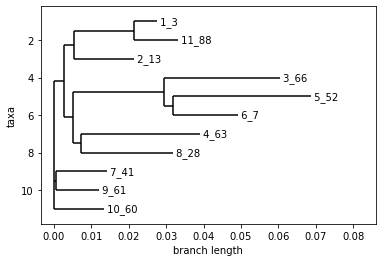

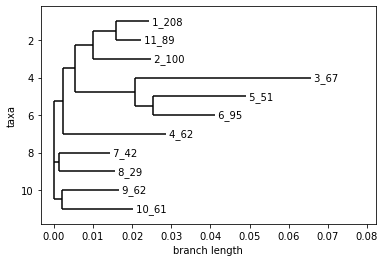

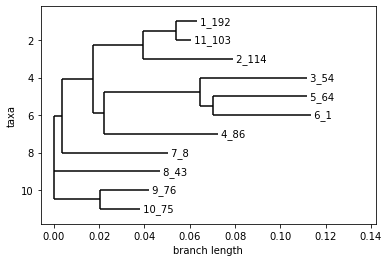

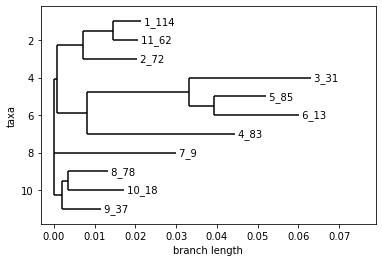

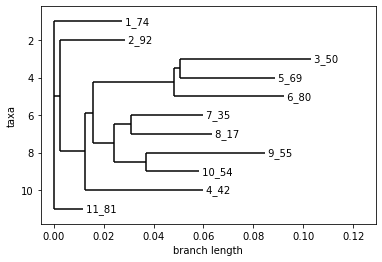

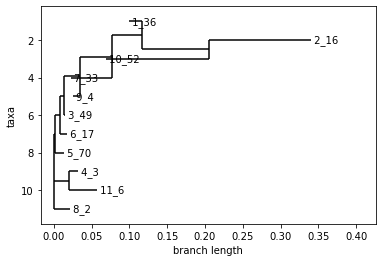

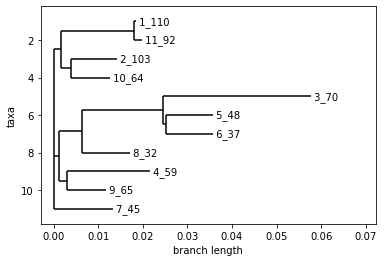

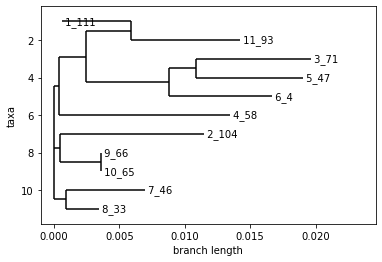

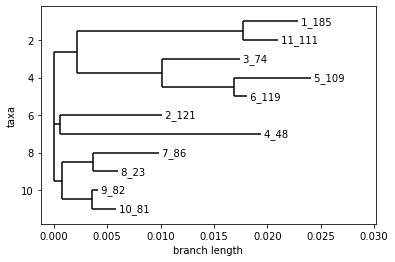

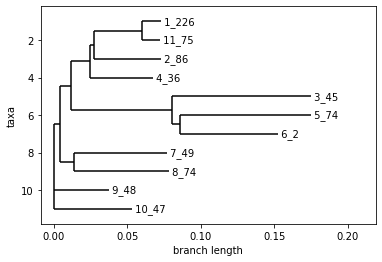

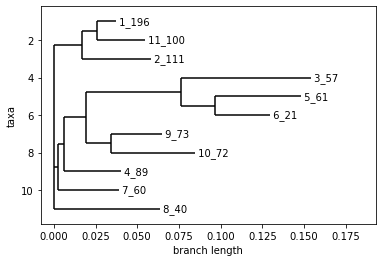

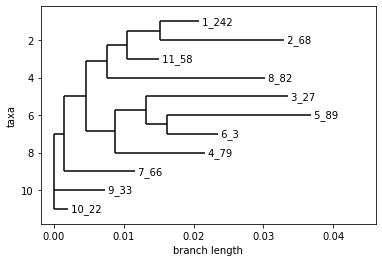

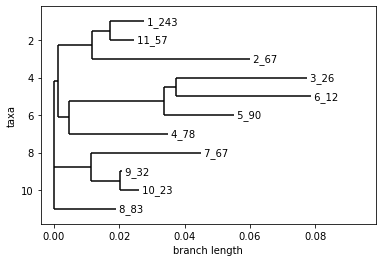

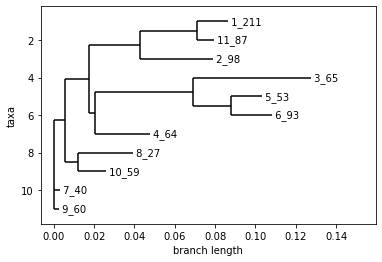

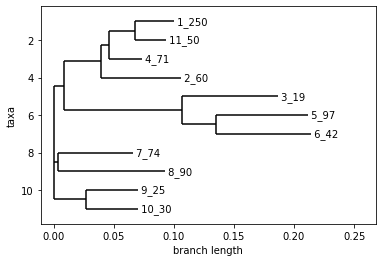

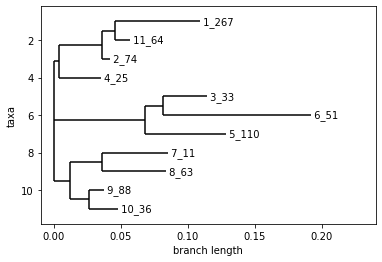

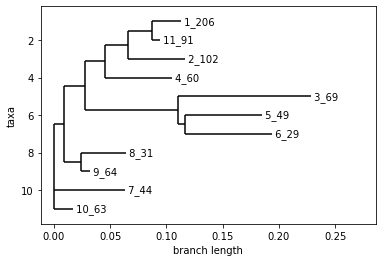

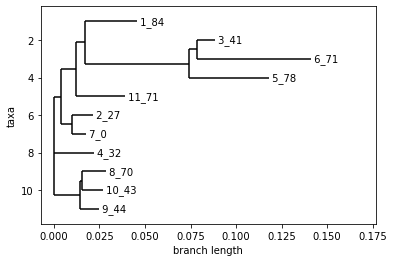

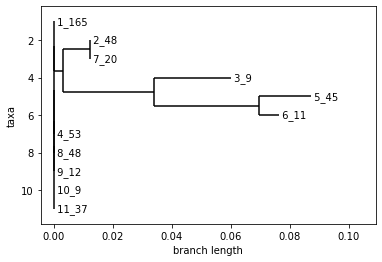

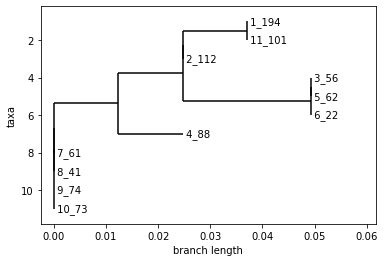

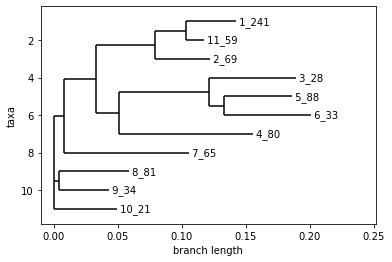

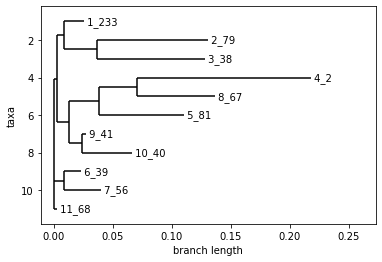

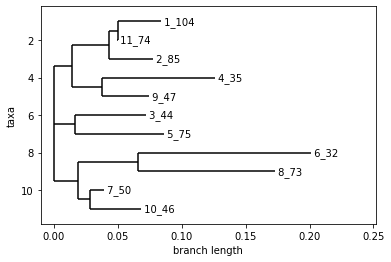

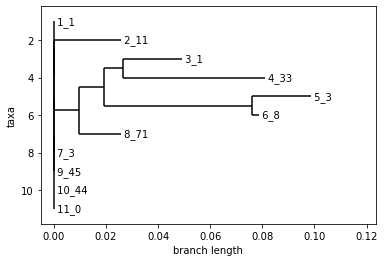

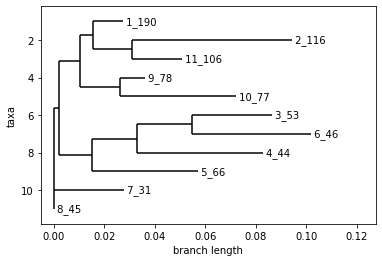

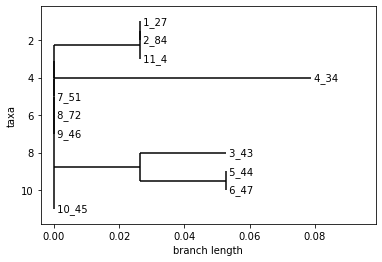

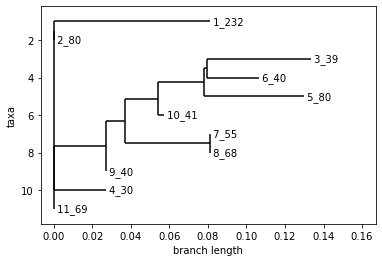

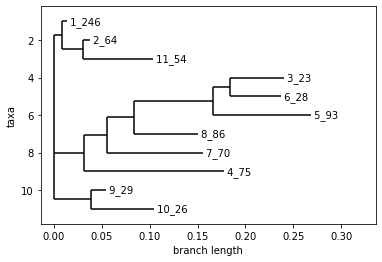

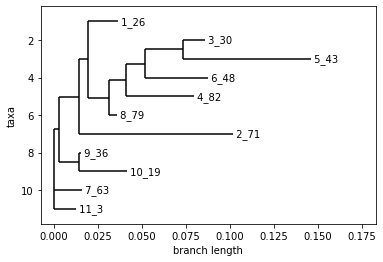

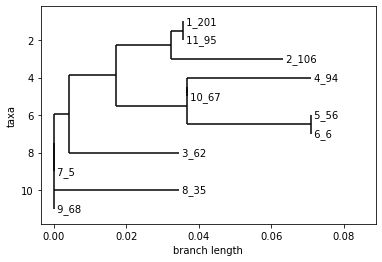

In [238]:
for i in range(1, n_seqs + 1):
    tree = Phylo.read("clustering_results/clustalw/" + str(i) + ".dnd", "newick")
    Phylo.draw(tree)

# Building phylogenetic trees

In [239]:
constructor = DistanceTreeConstructor()
calculator = DistanceCalculator('blosum45') # try different models maybe 
# protein_models = ['blosum45', 'blosum50', 'blosum62', 'blosum80', 'blosum90', 'pam250', 'pam30', 'pam70']

def build_tree_clustalw(i):
    aln = AlignIO.read("clustering_results/clustalw/" + str(i) + ".aln", "clustal")
    dm = calculator.get_distance(aln)
    return constructor.upgma(dm)

def build_tree_muscle(i):
    aln = AlignIO.read("clustering_results/muscle/" + str(i) + ".aln", "fasta")
    dm = calculator.get_distance(aln)
    return constructor.upgma(dm)

def label_display(label):
    if not label.name:
        return None
    elif label.name.startswith("Inner"):
        return ""
    else:
        number = int(label.name[:label.name.index("_")])
        return species_dict.get(number)[1]


### ClustalW trees

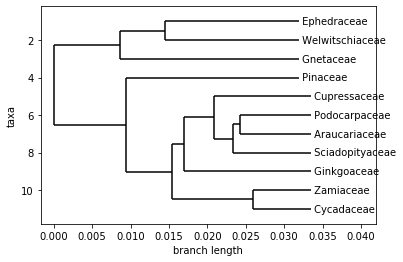

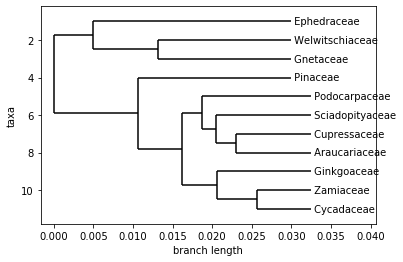

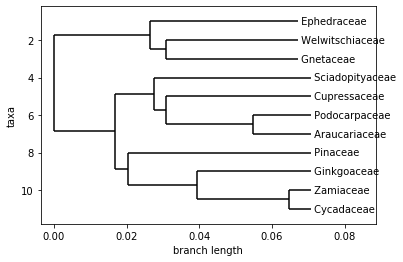

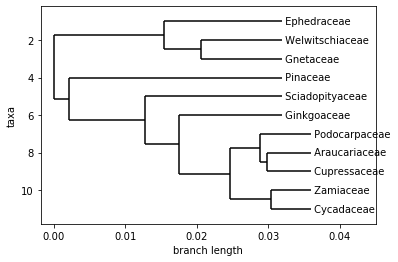

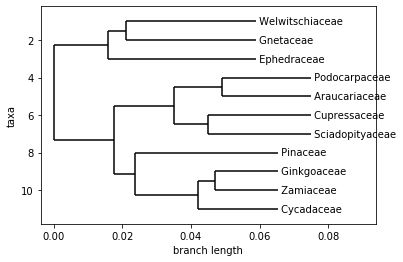

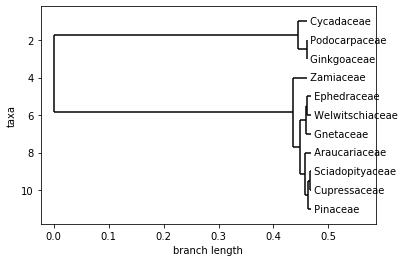

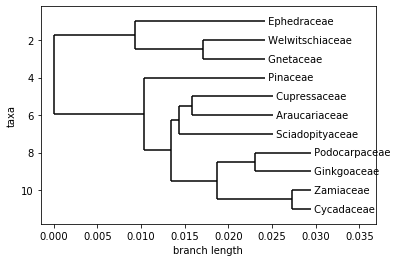

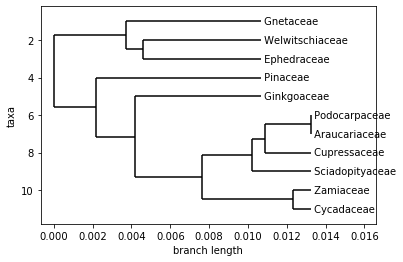

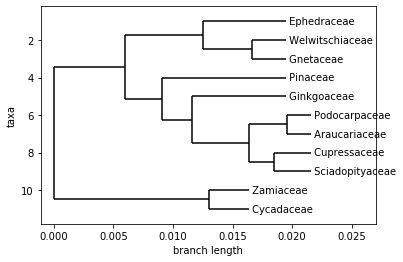

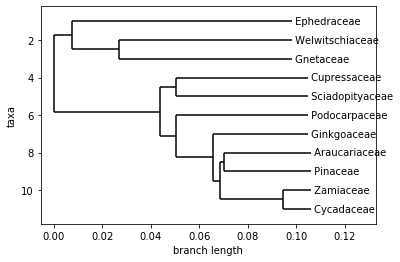

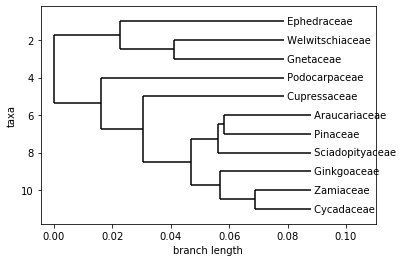

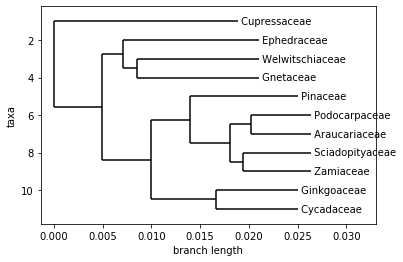

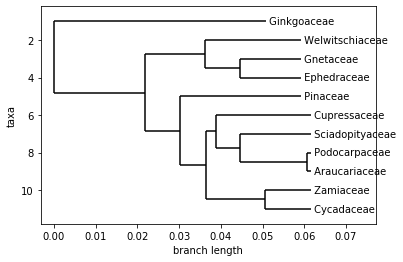

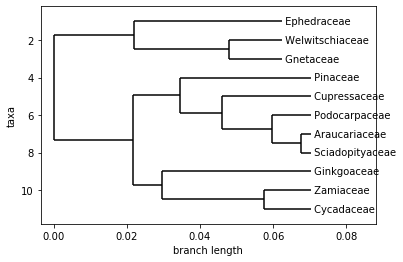

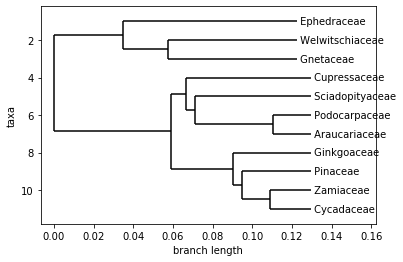

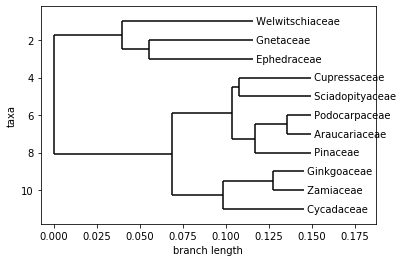

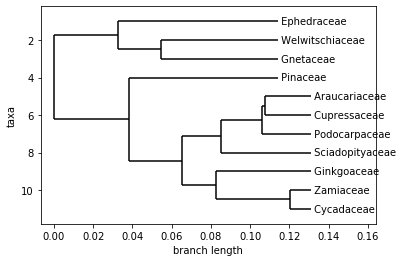

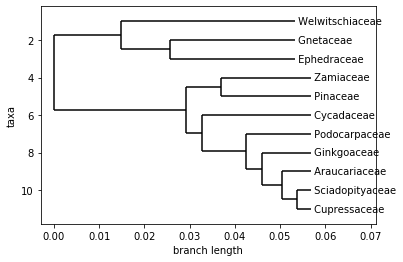

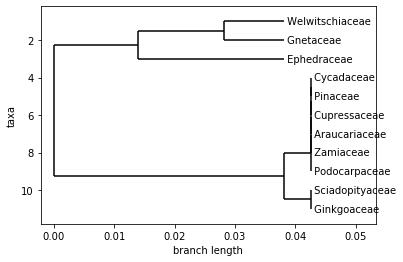

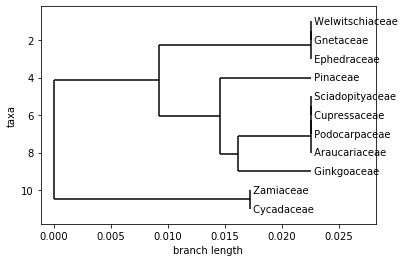

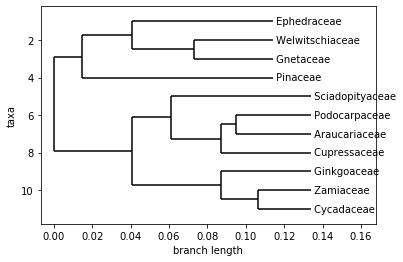

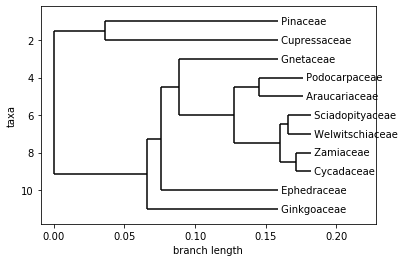

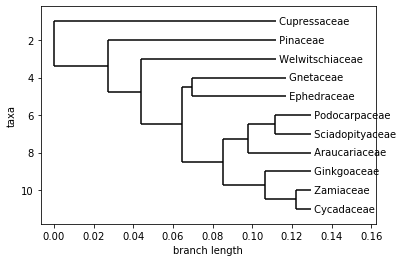

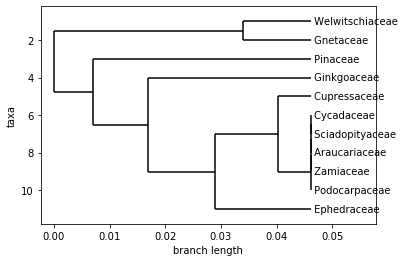

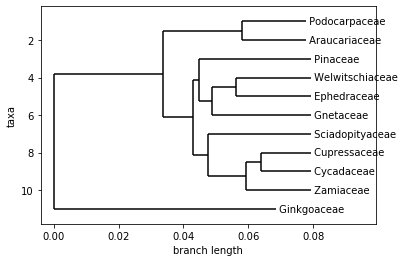

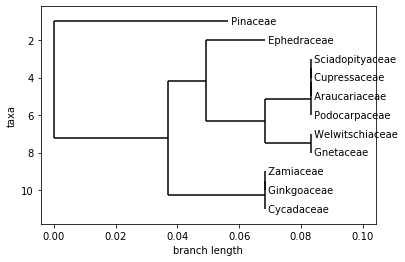

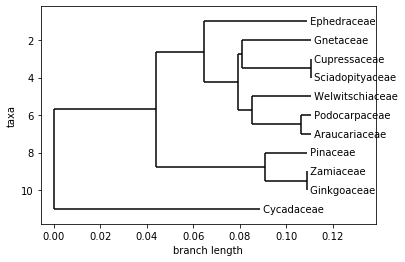

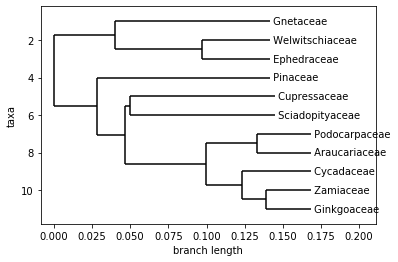

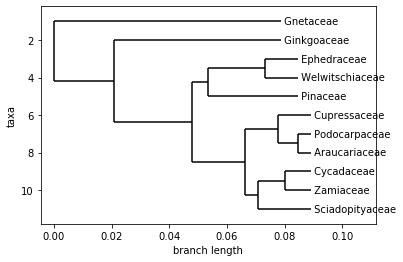

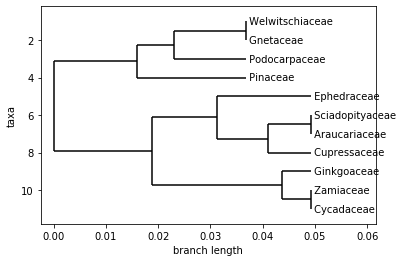

In [240]:
clustal_trees = list()
for i in range(1, n_seqs + 1):
    tree = build_tree_clustalw(i)
    clustal_trees.append(tree)
    Phylo.draw(tree, label_func=label_display)

### Muscle trees

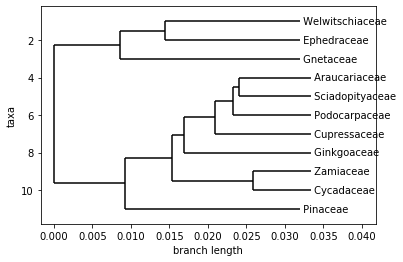

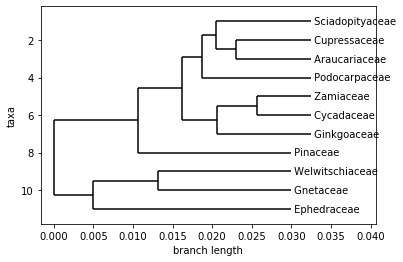

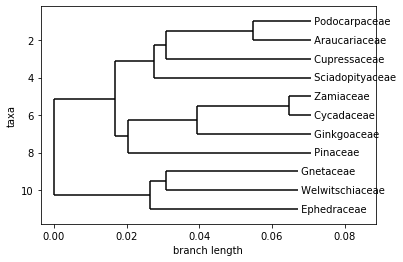

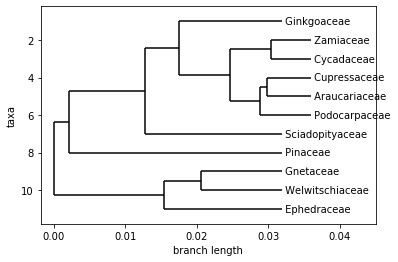

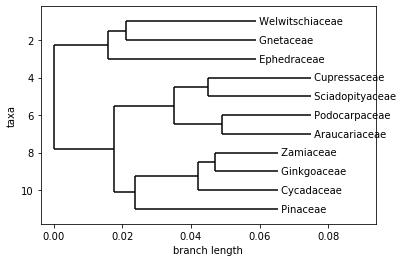

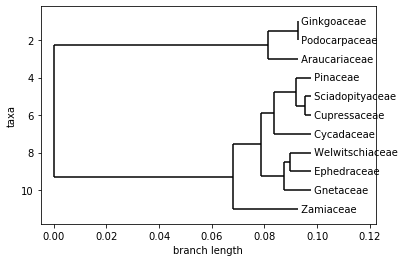

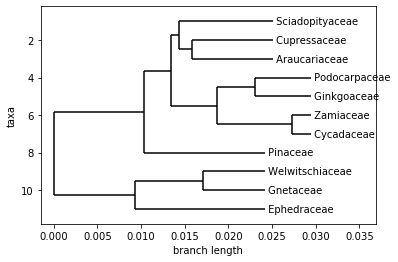

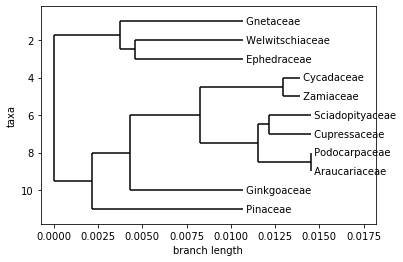

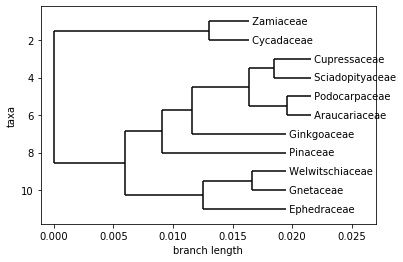

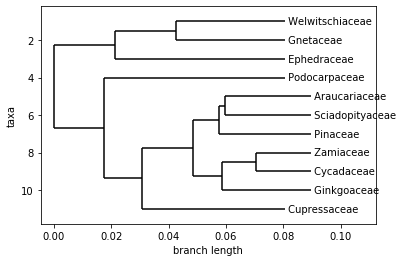

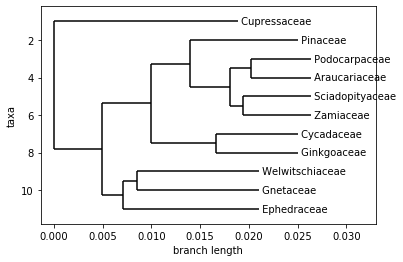

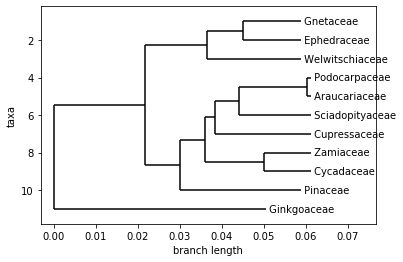

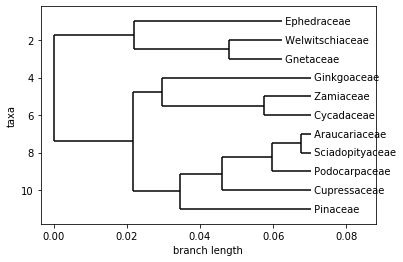

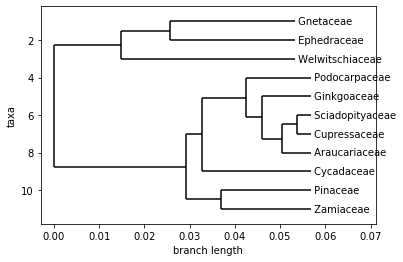

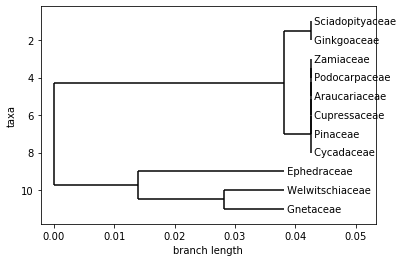

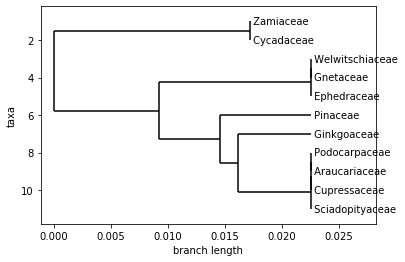

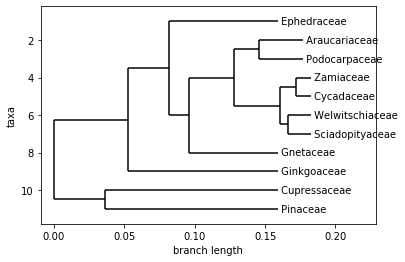

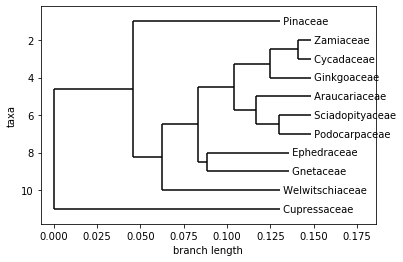

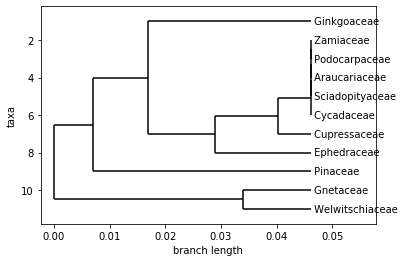

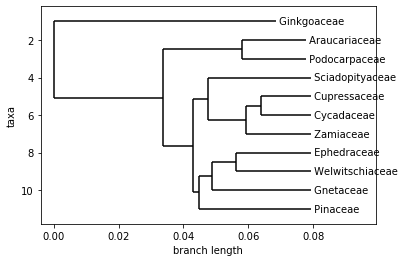

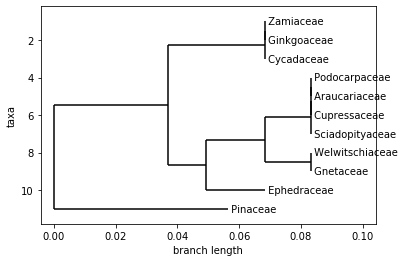

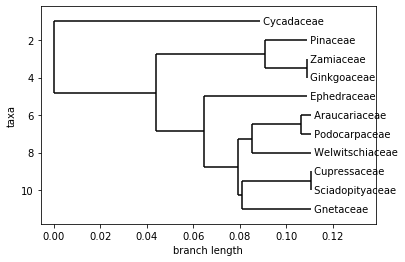

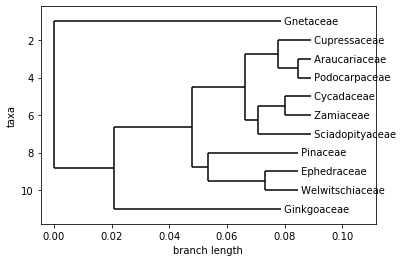

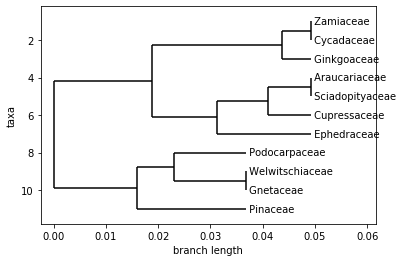

In [222]:
muscle_trees = list()
for i in range(1, n_seqs + 1):
    tree = build_tree_muscle(i)
    muscle_trees.append(tree)
    Phylo.draw(tree, label_func=label_display)

# Consensus Tree

#### Clustal

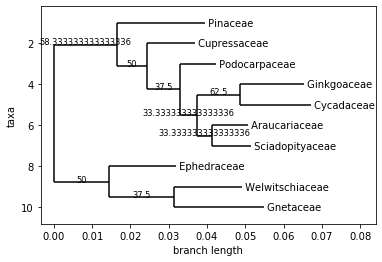

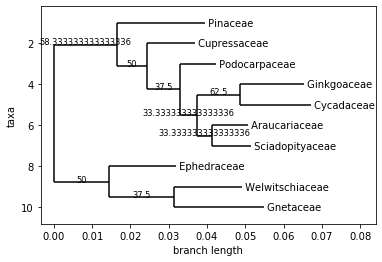

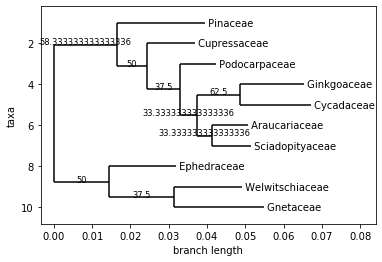

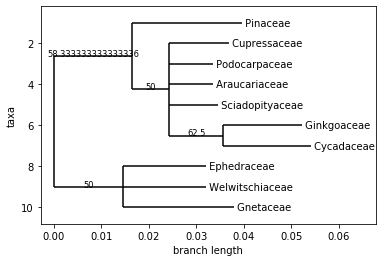

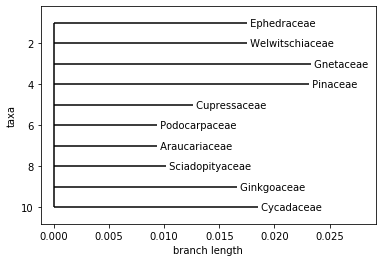

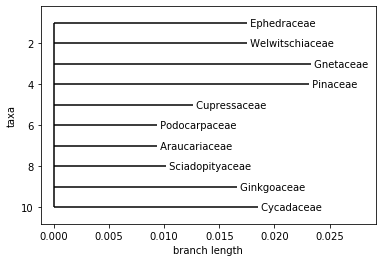

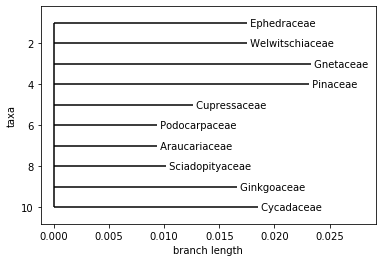

In [172]:
for cutoff in np.arange(0, 1.001, 1/6):
    clustal_majority_tree = majority_consensus(clustal_trees, cutoff)
    Phylo.draw(clustal_majority_tree, label_func=label_display)

### Muscle

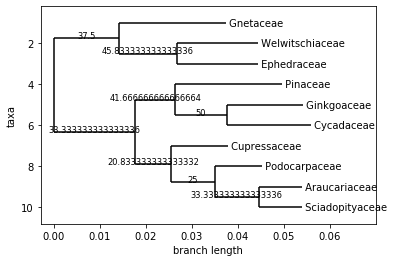

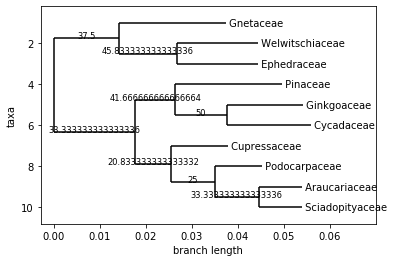

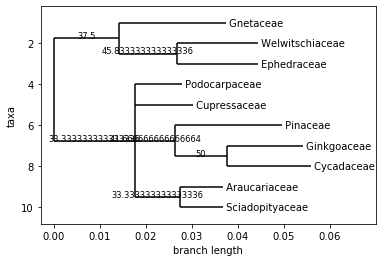

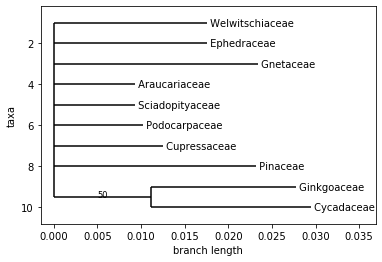

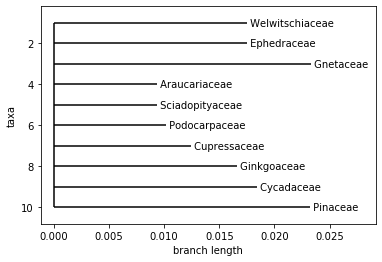

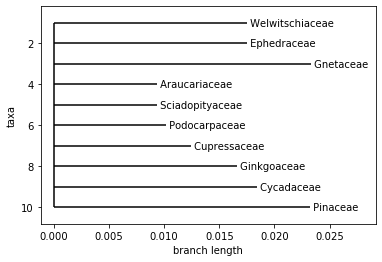

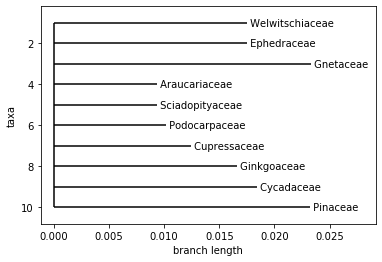

In [171]:
for cutoff in np.arange(0, 1.001, 1/6):
    muscle_majority_tree = majority_consensus(muscle_trees, cutoff)
    Phylo.draw(muscle_majority_tree, label_func=label_display)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])